In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpitree.tree import DecisionTreeClassifier

In [2]:
np.random.seed(42)

plt.rcParams["image.cmap"] = "Greys"
plt.rcParams["scatter.edgecolors"] = "k"

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data[:, :2], iris.target

In [4]:
estimators = [
    DecisionTreeClassifier(max_depth=depth).fit(X, y) for depth in (1, 2, 3, None)
]

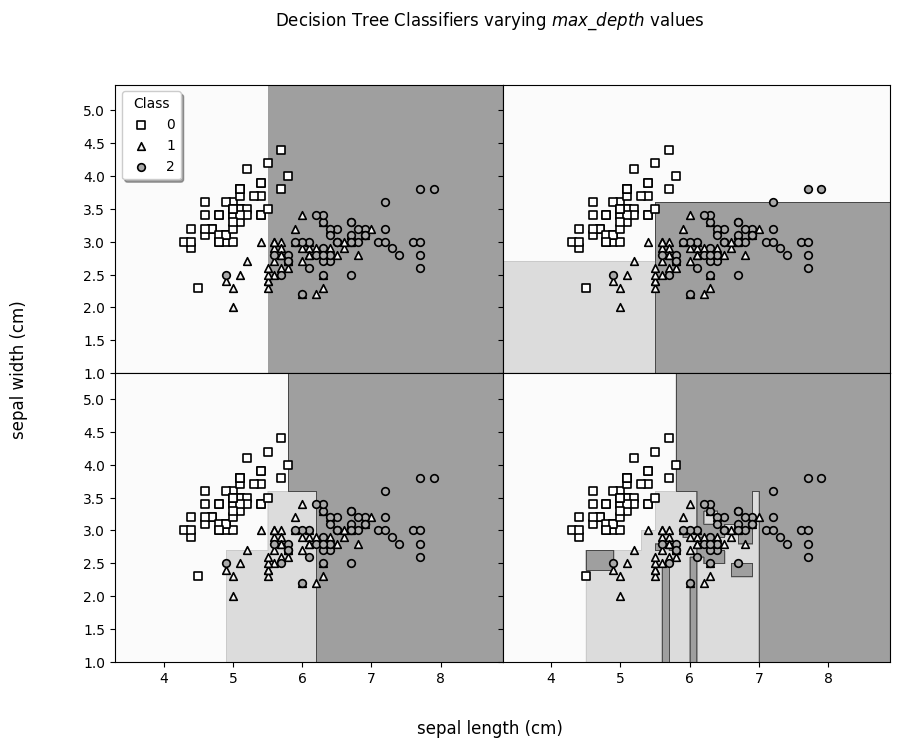

In [5]:
from itertools import product

n_classes = np.unique(y)
colors = "w", "whitesmoke", "darkgray"
markers = list("s^o")

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

n_rows, n_cols = 2, 2
fig, axs = plt.subplots(
    n_rows,
    n_cols,
    sharex="col",
    sharey="row",
    figsize=(10, 7.5),
    gridspec_kw={"wspace": 0, "hspace": 0},
)

for (i, j), clf in zip(product(*map(range, [n_rows, n_cols])), estimators):
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    axs[i, j].contourf(xx, yy, z, alpha=0.4)

    for t, c, marker in zip(n_classes, colors, markers):
        axs[i, j].scatter(
            X[y == t, 0],
            X[y == t, 1],
            c=c,
            s=30,
            linewidth=1.2,
            marker=marker,
            label=t,
        )

axs[0, 0].legend(title="Class", loc="upper left", shadow=True)

fig.suptitle("Decision Tree Classifiers varying $max\_depth$ values")
fig.supxlabel("sepal length (cm)")
fig.supylabel("sepal width (cm)")

plt.show()

In [6]:
print(estimators[3])

┌── feature_0
│  ├── feature_1 [> 5.5]
│  │  ├── feature_0 [> 3.6]
│  │  │  └── class: 2 [> 5.8]
│  │  │  └── class: 0 [<= 5.8]
│  │  ├── feature_0 [<= 3.6]
│  │  │  ├── feature_0 [> 6.2]
│  │  │  │  ├── feature_0 [<= 7.0]
│  │  │  │  │  ├── feature_1 [<= 6.9]
│  │  │  │  │  │  ├── feature_0 [> 2.3]
│  │  │  │  │  │  │  ├── feature_1 [> 6.5]
│  │  │  │  │  │  │  │  ├── feature_0 [<= 3.1]
│  │  │  │  │  │  │  │  │  ├── feature_1 [> 6.6]
│  │  │  │  │  │  │  │  │  │  ├── feature_1 [> 2.5]
│  │  │  │  │  │  │  │  │  │  │  ├── feature_0 [> 2.8]
│  │  │  │  │  │  │  │  │  │  │  │  ├── feature_0 [> 6.7]
│  │  │  │  │  │  │  │  │  │  │  │  │  └── class: 2 [> 6.8]
│  │  │  │  │  │  │  │  │  │  │  │  │  └── class: 2 [<= 6.8]
│  │  │  │  │  │  │  │  │  │  │  │  ├── feature_1 [<= 6.7]
│  │  │  │  │  │  │  │  │  │  │  │  │  └── class: 1 [> 3.0]
│  │  │  │  │  │  │  │  │  │  │  │  │  └── class: 1 [<= 3.0]
│  │  │  │  │  │  │  │  │  │  │  └── class: 1 [<= 2.8]
│  │  │  │  │  │  │  │  │  │  └── class

In [7]:
# n_classes = np.unique(y)
# colors = "w", "darkgray"
# markers = list("s^")

# plt.figure()

# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
# plt.contourf(xx, yy, Z, alpha=0.4, cmap="Greys")

# for t, c, marker in zip(n_classes, colors, markers):
#     plt.scatter(
#         X[y == t, 0],
#         X[y == t, 1],
#         c=c,
#         s=30,
#         linewidth=1.2,
#         marker=marker,
#         label=t,
#     )

# plt.legend(title="Class", loc="upper left", shadow=True)
# plt.show()